In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
%watermark

Last updated: 2024-07-20T10:23:04.835762-04:00

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

Compiler    : MSC v.1937 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 167 Stepping 1, GenuineIntel
CPU cores   : 16
Architecture: 64bit



In [2]:
# Libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

import os

from func_utils import *

# kmeans (for item 3)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# classification model (for item 4)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Display and graph options

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Customize the font and title size
custom_params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "font.family": "Arial"
}
sns.set_context("notebook", rc=custom_params)

# Set a color palette
sns.set_palette("Set2") 

# Set global option to display numbers in plain format
pd.set_option('display.float_format', '{:.2f}'.format)

# Filter warnings and seeds
import warnings
import random

warnings.filterwarnings('ignore')
random.seed(1234)

In [3]:
# Data 

data_tmp = pd.read_csv('DATA/base_main.csv')

In [4]:
data_tmp.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,...,Transaction_Date2,Month,Coupon_Code,Discount_pct,Discount_pct_ajus,Invoice,Gender,Location,Tenure_Months,month
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,2019-01-01,Jan,ELEC10,10.00,10.00,194.37,M,Chicago,12,1
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,2019-01-01,Jan,ELEC10,10.00,10.00,194.37,M,Chicago,12,1
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used,...,2019-01-01,Jan,OFF10,10.00,10.00,9.01,M,Chicago,12,1
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used,...,2019-01-01,Jan,SALE10,10.00,0.00,109.93,M,Chicago,12,1
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used,...,2019-01-01,Jan,AIO10,10.00,10.00,28.13,M,Chicago,12,1


# 3. Performing Customer Segmentation
### 3.1. Heuristic (Value based, RFM) – Divide the customers into Premium, Gold, Silver, Standard customers and define strategy on the same.

RFM analysis is a data driven customer behavior segmentation technique. RFM stands for recency, frequency, and monetary value.
The  idea is to segment customers based on when their last purchase was, how often they’ve purchased in the past, and how much they’ve spent overall.


To calculate the RFM score, I will follow these steps:

1. Assign scores: For each of the RFM factors, assign scores on a scale from 1 to 5, where 5 is the highest value (most recent, most frequent, highest monetary).
2. Score Recency: Customers who purchased most recently get the highest scores.
3. Score Frequency: Customers who purchased most frequently get the highest scores.
4. Score Monetary: Customers who spent the most get the highest scores.

~~Combine the scores: Concatenate the individual scores to get a three-digit number representing the RFM score. For example, if a customer has Recency = 5, Frequency = 3, and Monetary = 4, their RFM score would be 534.~~

After some tests with this previous method, I changed the function to the sum of the scores. In the other method, Recency has a huge impact on the final result.

*Important* to notice that are other mehtods and aggregations to the final score. For example, we can assign different weights based on the importance of each variable.    
In the EDA file, I included another way to calculate using Recency x (Frequency + Monetary) and concatenating the values.

In [5]:
# Recency
data_tmp['Transaction_Date'] = pd.to_datetime(data_tmp['Transaction_Date'])

# Calculating a reference date (last purchase)
data_ref = data_tmp['Transaction_Date'].max()

# Grouping and calculating the recency
recency_tmp = data_tmp.groupby('CustomerID')['Transaction_Date'].agg('max').reset_index(name = 'last_purchase')
recency_tmp['recency_days'] = (data_ref - recency_tmp['last_purchase']).dt.days

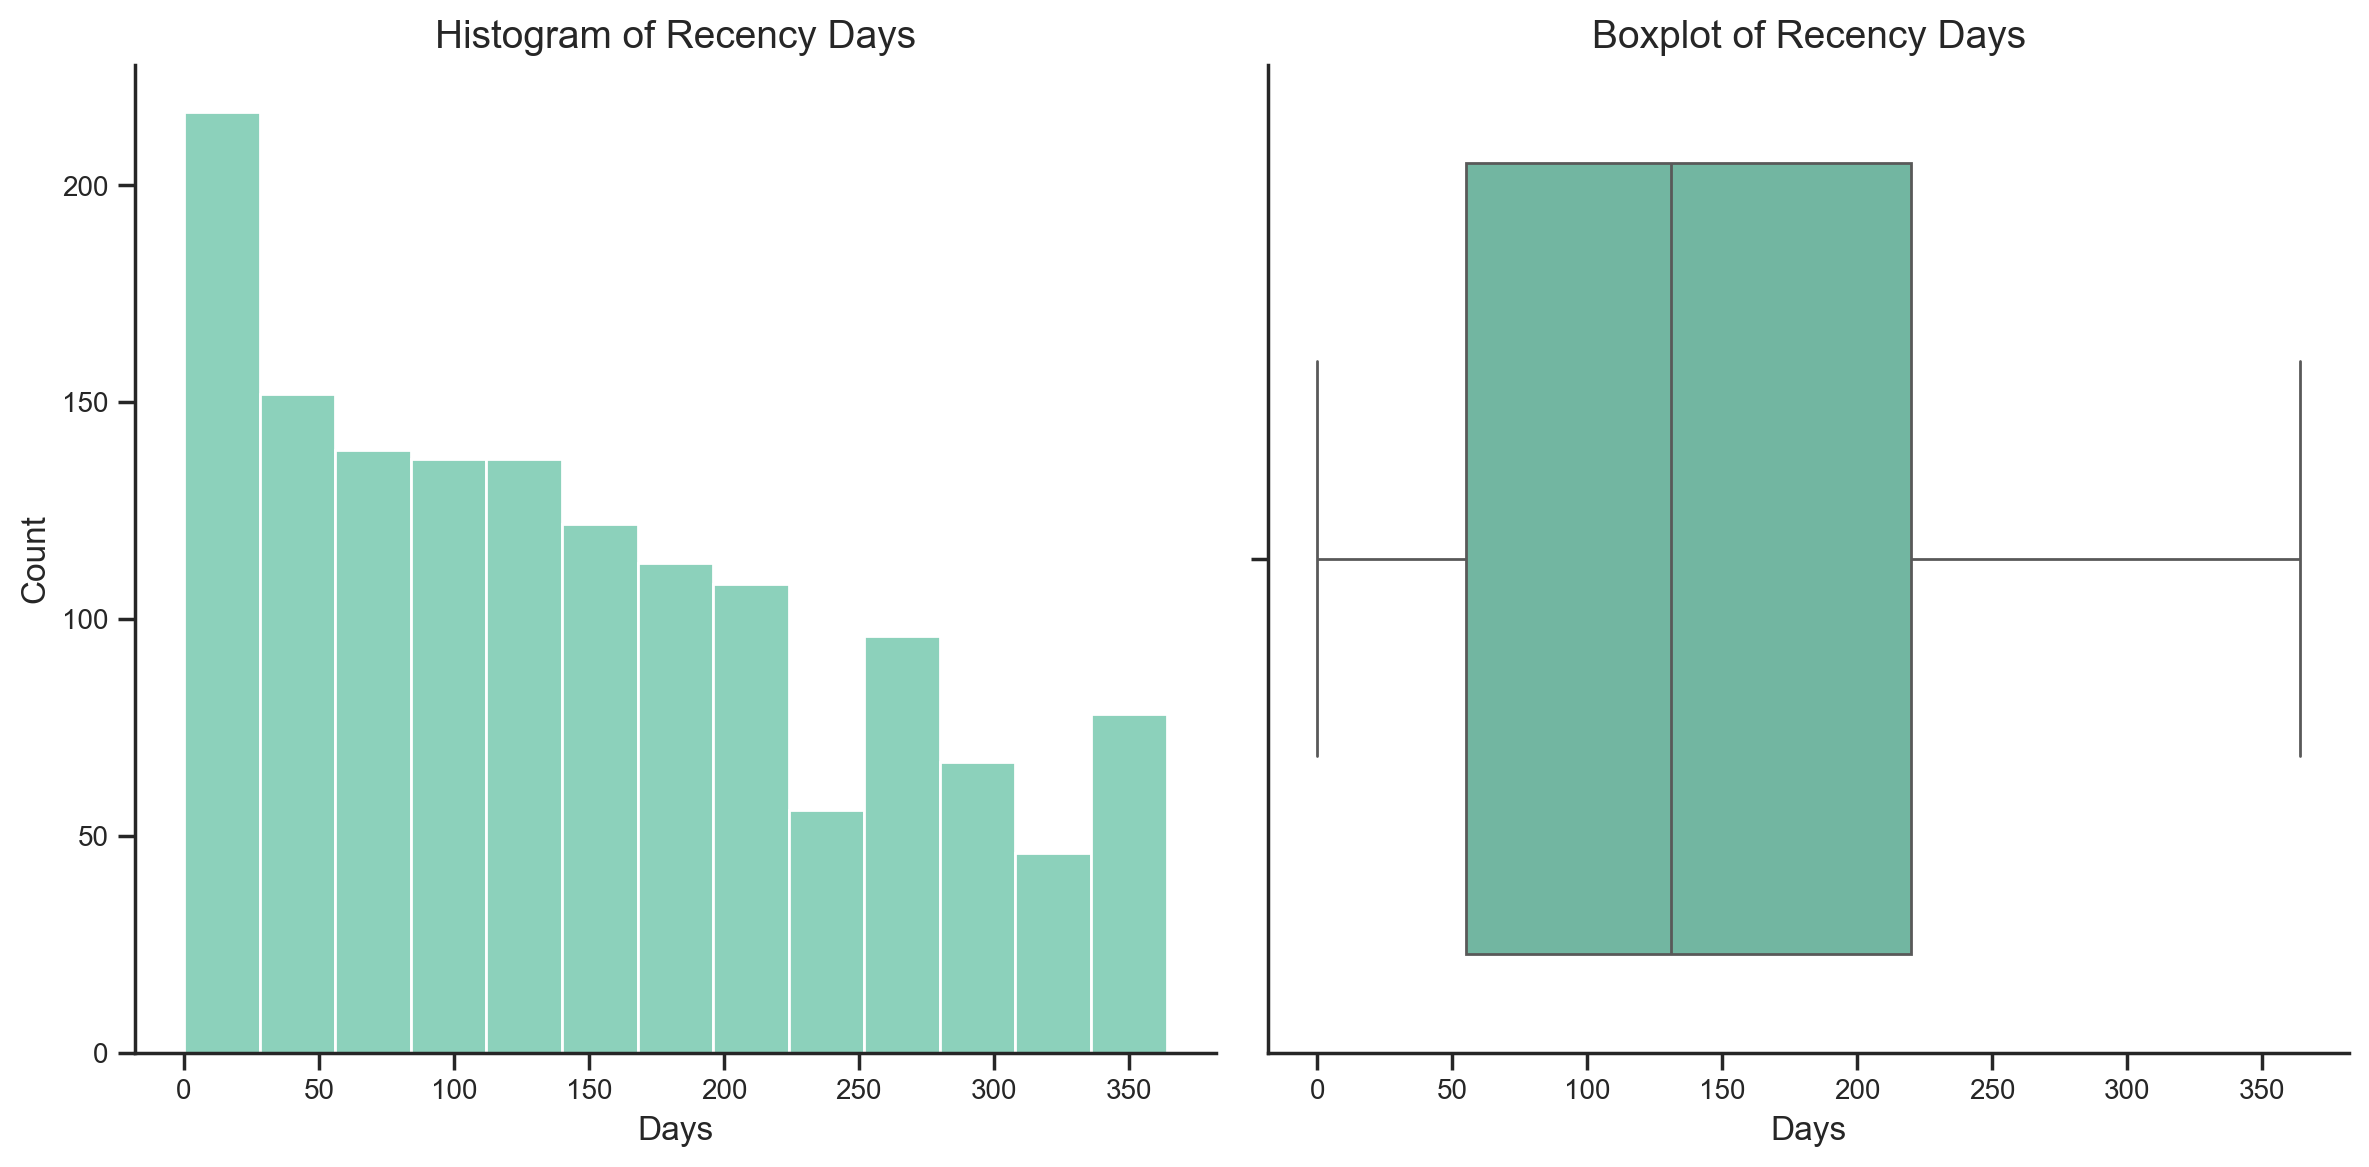

In [6]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram
sns.histplot(recency_tmp['recency_days'], ax=axes[0])
axes[0].set_title('Histogram of Recency Days')
axes[0].set_xlabel('Days')  # Rótulo do eixo X
axes[0].set_ylabel('Count')  # Rótulo do eixo Y

# Boxplot
sns.boxplot(x=recency_tmp['recency_days'], ax=axes[1])
axes[1].set_title('Boxplot of Recency Days')
axes[1].set_xlabel('Days')  # Rótulo do eixo X

# Adjust layout
plt.tight_layout()
plt.show()

In [7]:
# Assign the labels for recency

recency_tmp['recency_score'] = pd.qcut(recency_tmp['recency_days'], 5, labels = [5,4,3,2,1])
recency_tmp['recency_score'] = recency_tmp['recency_score'].astype(int)

In [8]:
# Frequency

frequency = data_tmp['CustomerID'].value_counts().reset_index(name = 'frequency')
frequency['frequency'].describe()

count   1468.00
mean      36.05
std       50.89
min        1.00
25%       10.00
50%       21.00
75%       46.00
max      695.00
Name: frequency, dtype: float64

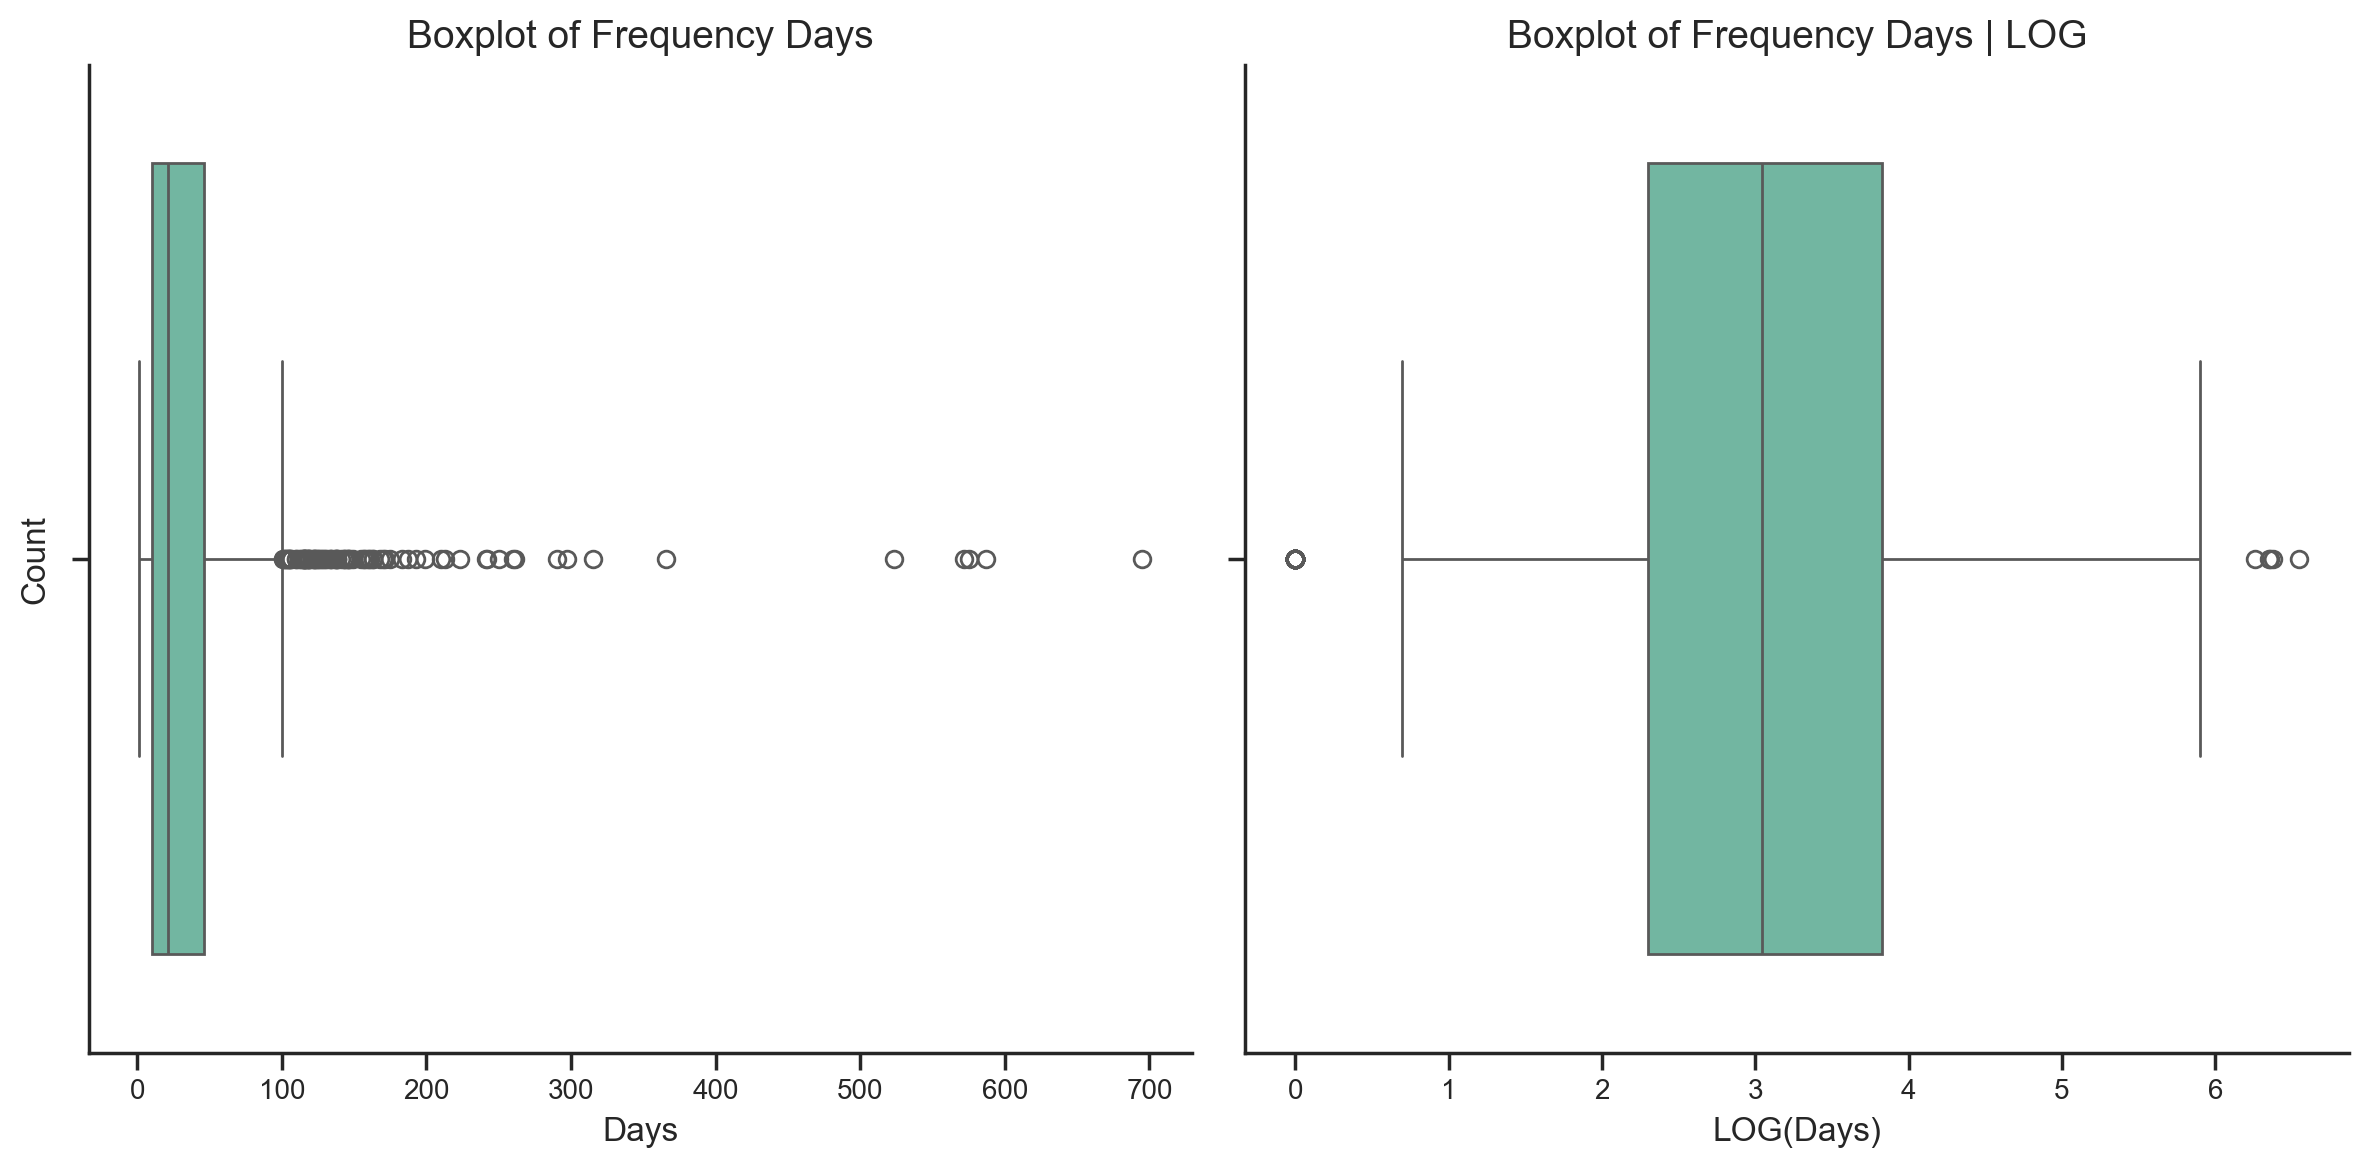

In [9]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

frequency_log = np.log(frequency['frequency'])

# Histogram
sns.boxplot(x = frequency['frequency'], ax=axes[0])
axes[0].set_title('Boxplot of Frequency Days')
axes[0].set_xlabel('Days')  
axes[0].set_ylabel('Count')  

# Boxplot
sns.boxplot(x=frequency_log, ax=axes[1])
axes[1].set_title('Boxplot of Frequency Days | LOG')
axes[1].set_xlabel('LOG(Days)')  


plt.tight_layout()
plt.show()

In [10]:
# Assign the labels for frequency

frequency['frequency_score'] = pd.qcut(frequency['frequency'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop').astype(int)

In [11]:
# Monetary

monetary = data_tmp.groupby(['CustomerID'])['Invoice'].agg('sum').reset_index()

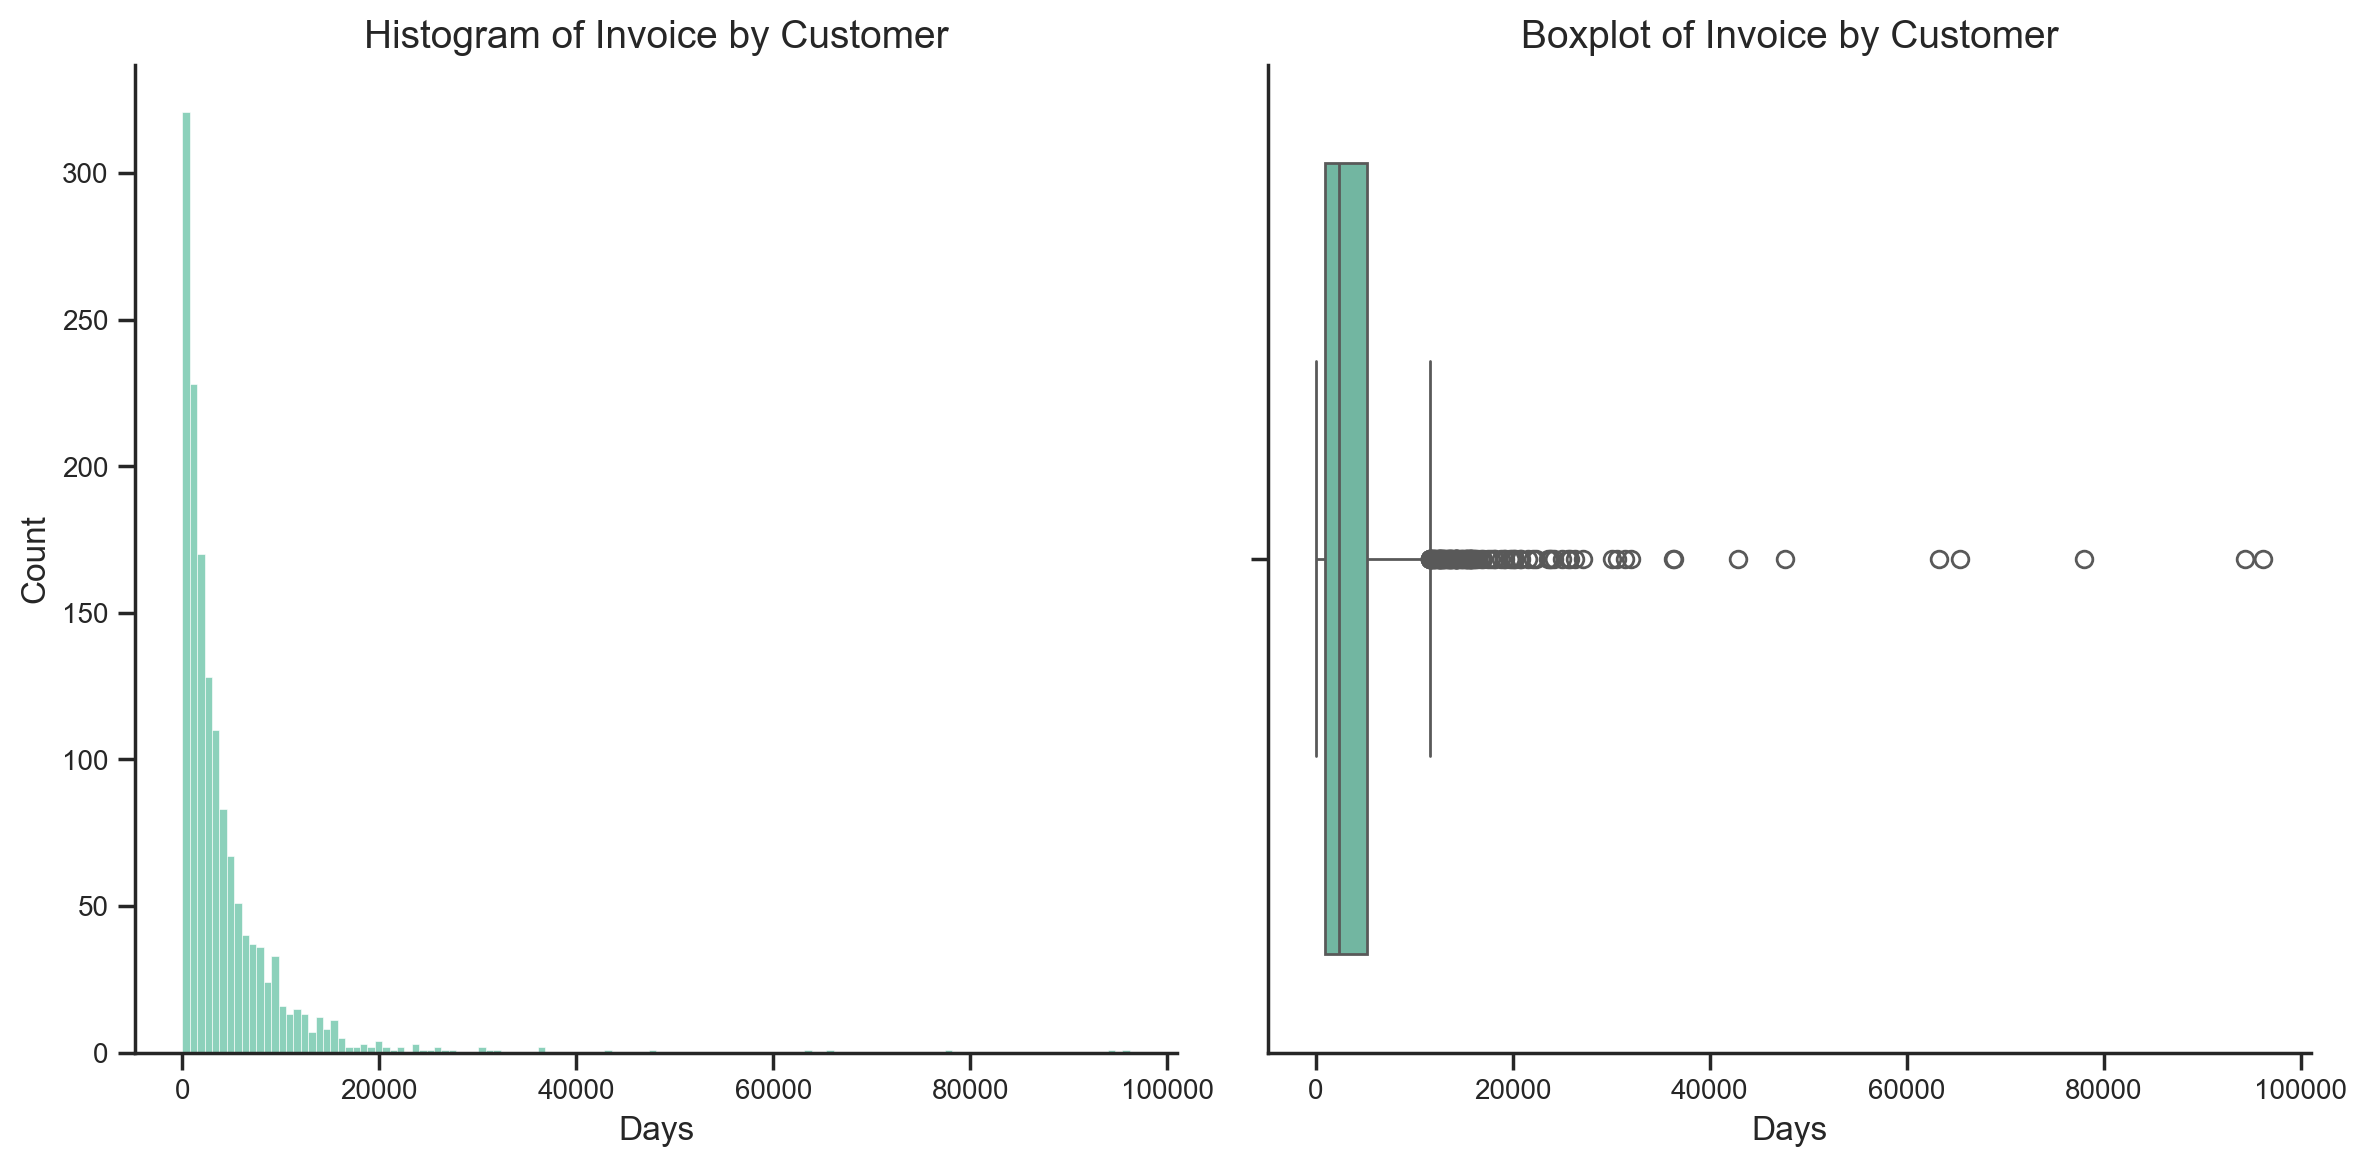

In [12]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram
sns.histplot(monetary['Invoice'], ax=axes[0])
axes[0].set_title('Histogram of Invoice by Customer')
axes[0].set_xlabel('Days')  
axes[0].set_ylabel('Count') 

# Boxplot
sns.boxplot(x=monetary['Invoice'], ax=axes[1])
axes[1].set_title('Boxplot of Invoice by Customer')
axes[1].set_xlabel('Days')  

# Adjust layout
plt.tight_layout()
plt.show()

In [13]:
# Assign labels for monetary

monetary['invoice_score'] = pd.qcut(monetary['Invoice'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop').astype(int)


In [14]:
# Combining the bases

data_rfm_tmp = monetary.merge(frequency, on='CustomerID', how='left').merge(recency_tmp, on='CustomerID', how='left')
data_rfm_tmp.head(3)

,CustomerID,Invoice,invoice_score,frequency,frequency_score,last_purchase,recency_days,recency_score
0,12346,200.98,1,2,1,2019-09-15,107,3
1,12347,17772.35,5,60,5,2019-11-02,59,4
2,12348,2046.76,3,23,3,2019-10-19,73,4


In [15]:
# Saving the base to test another ways in EDA analysis

data_rfm_tmp.to_csv('DATA/data_rfm_tmp.csv')

In [16]:
## RFM Score

data_rfm_tmp['rfm_score'] = data_rfm_tmp[['recency_score', 'frequency_score', 'invoice_score']].sum(axis=1)
data_rfm_tmp['rfm_label'] = pd.qcut(data_rfm_tmp['rfm_score'], 4, labels = range(1,5))

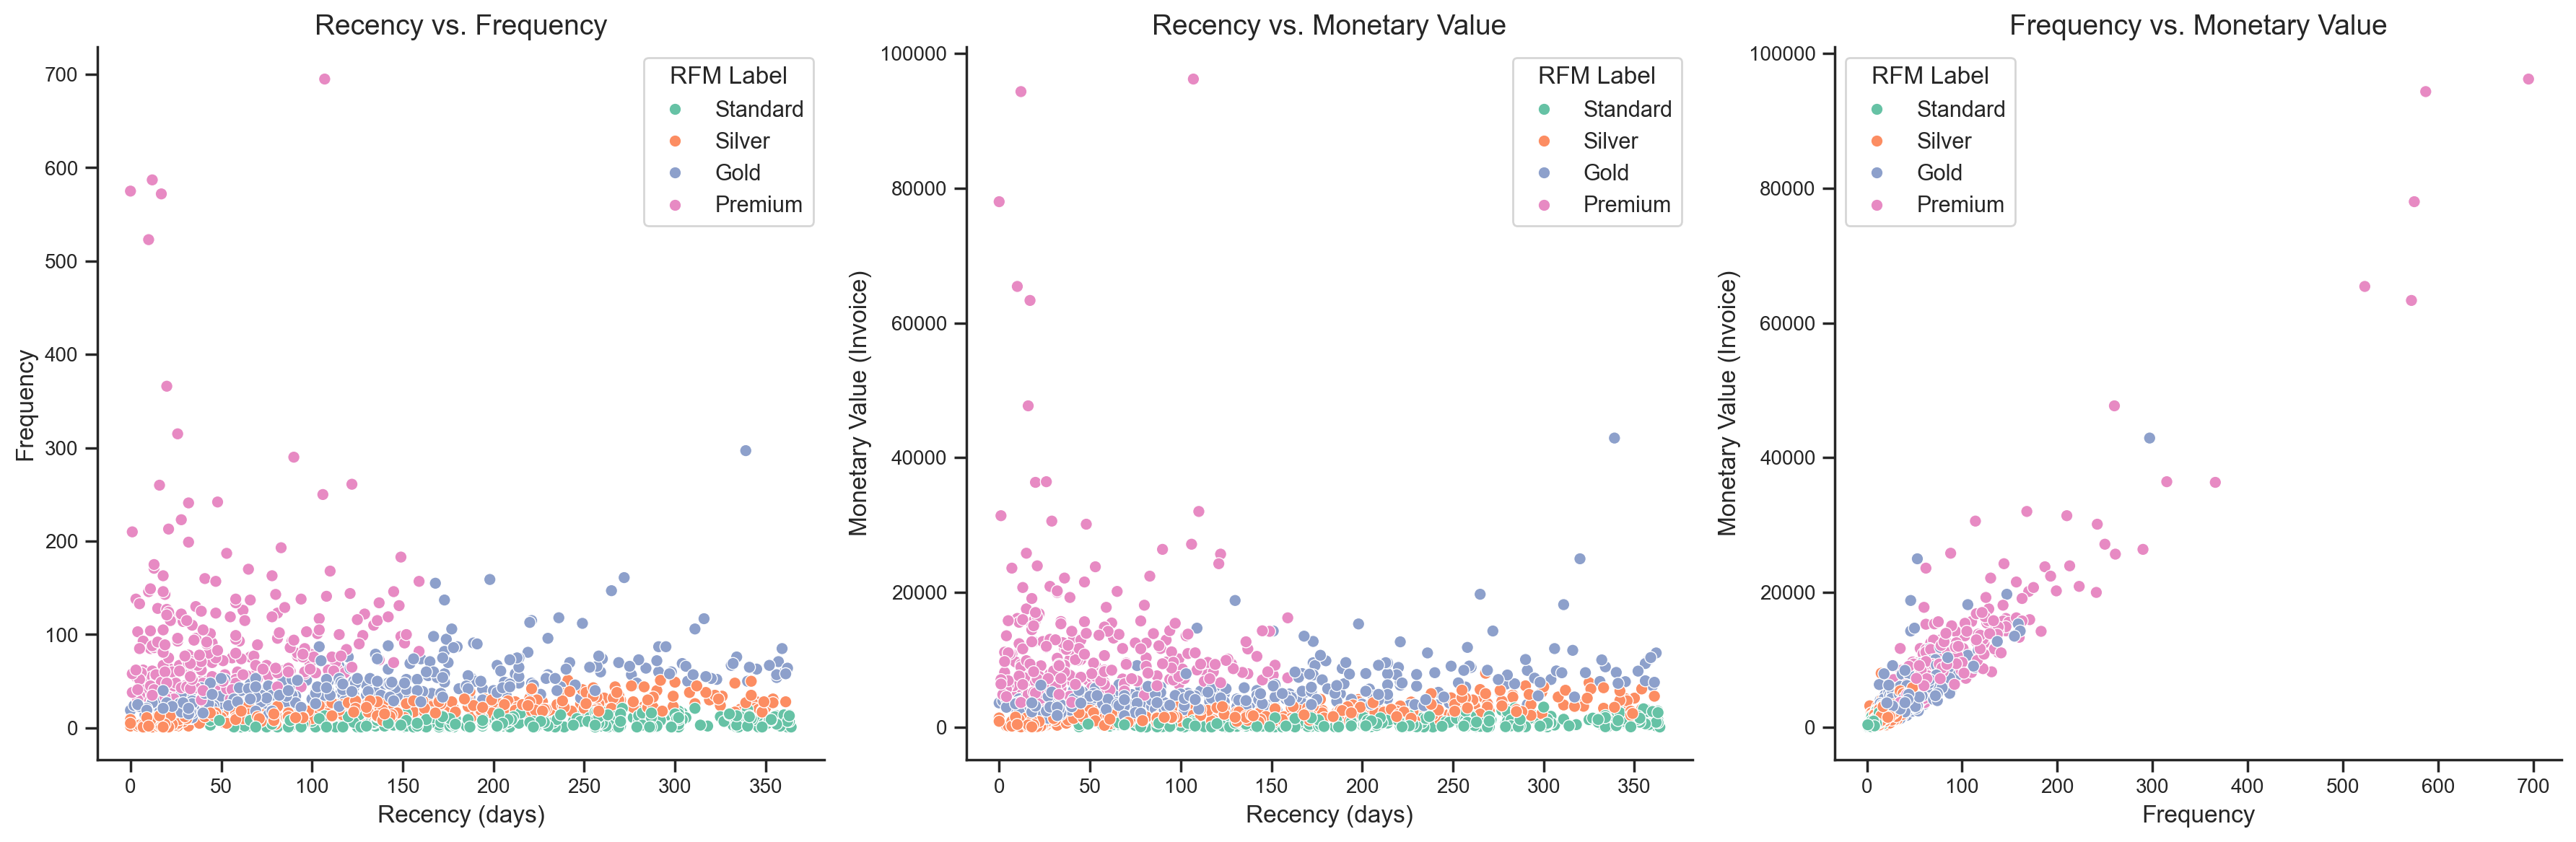

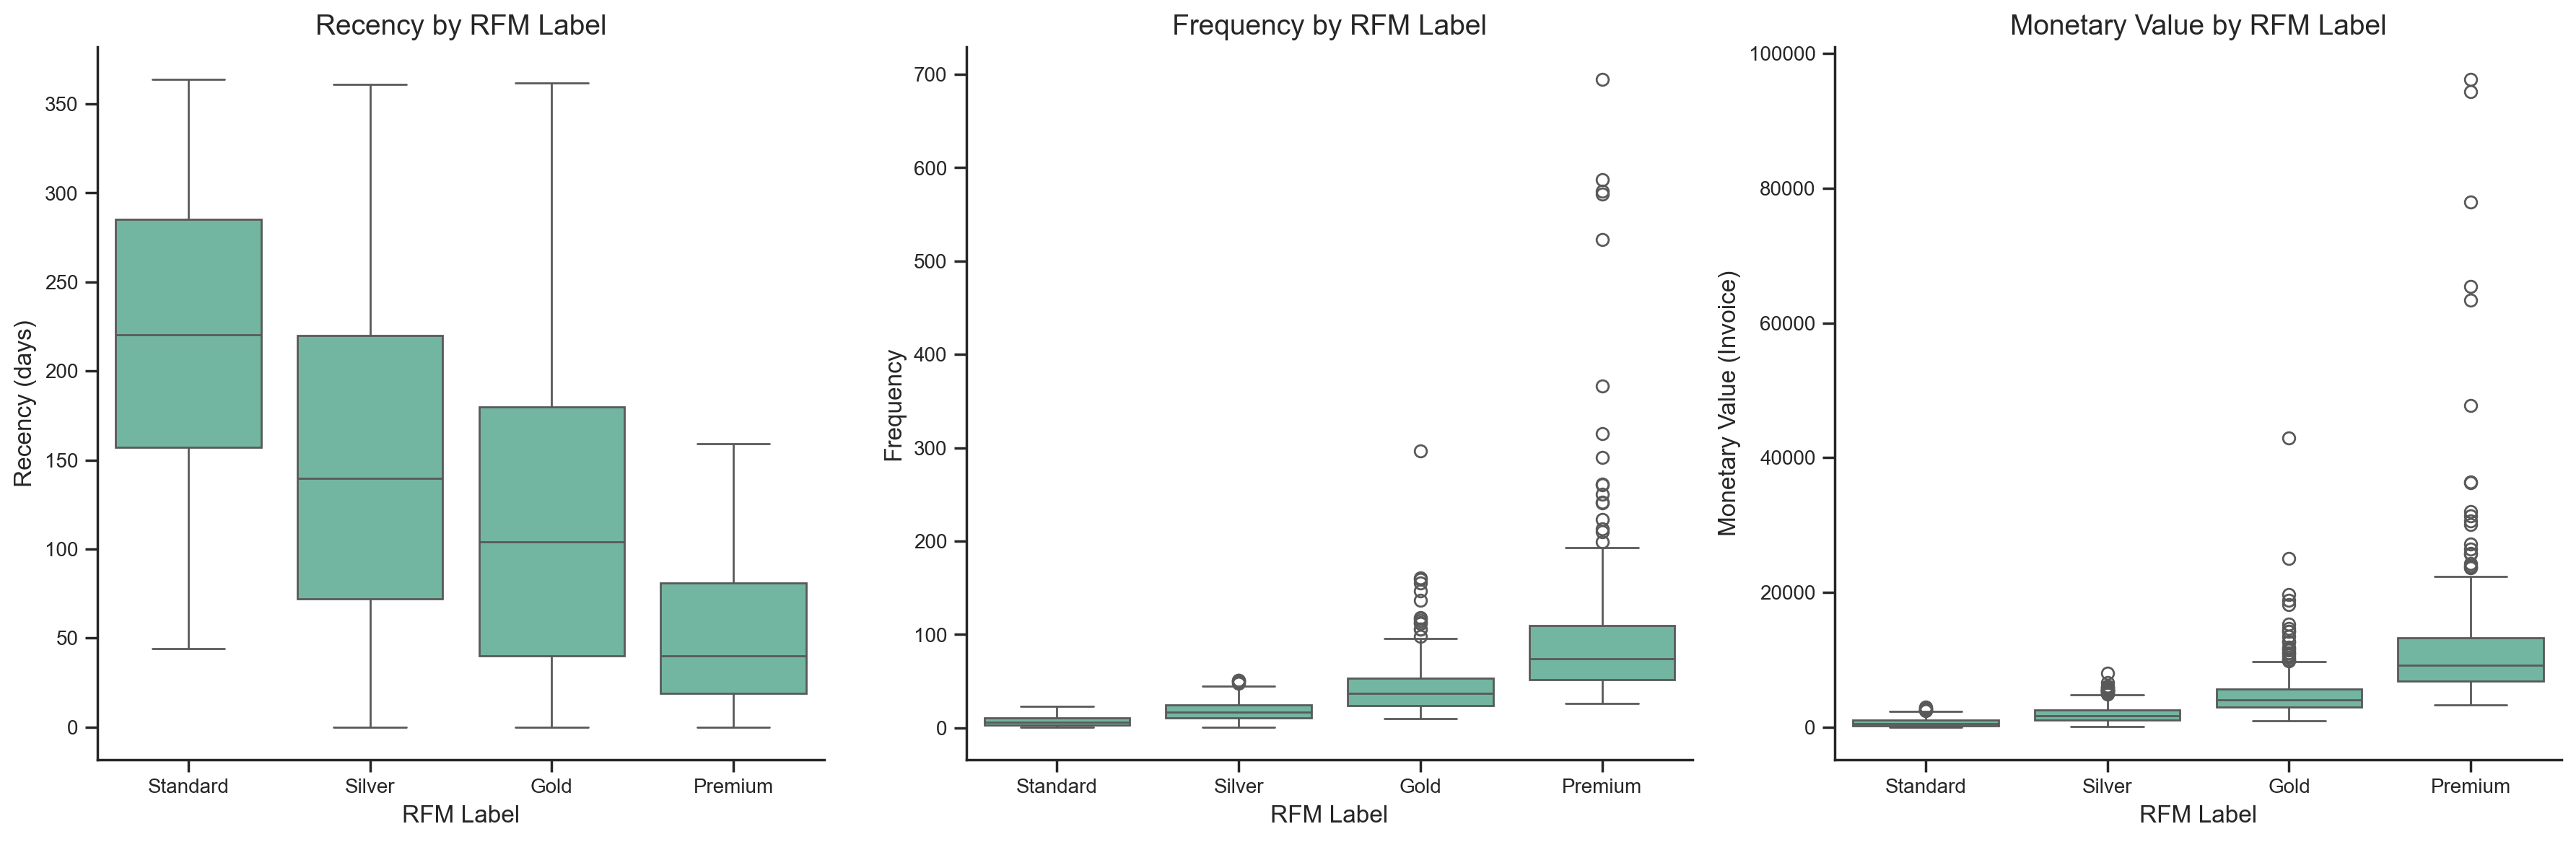

In [17]:
# Plot the Groups

## I plotted the data before and defined the labels for each group considerinf the names: Premium, Gold, Silver and Standart

# Mapping dictionary
rfm_mapping = {
    4: 'Premium',
    3: 'Gold',
    2: 'Silver',
    1: 'Standard'
}

# Apply the mapping to the RFM labels
data_rfm_tmp['rfm_label_rename'] = data_rfm_tmp['rfm_label'].map(rfm_mapping)

plot_rfm_clusters(data_rfm_tmp, 'recency_days', 'frequency', 'Invoice', 'rfm_label_rename')

**Strategies for Each Segment**
1. Premium Customers
    - **Personalized Offers**: Send personalized offers and discounts to encourage repeat purchases.
    - **Exclusive Previews**: Offer exclusive previews of new products.
    - **Loyalty Programs**: Create a loyalty program that rewards frequent purchases with points or discounts.
    - **Premium Services**: Provide premium services like free shipping, early access to sales, and dedicated customer support.
2. Gold Customers
    - **Upsell and Cross-Sell**: Recommend higher-end products or complementary items based on their purchase history.
    - **Engagement Campaigns**: Send regular newsletters with updates and special offers to keep them engaged.
    - **Feedback Requests**: Ask for feedback to understand their needs better and tailor offerings accordingly.
3. Silver Customers
    - **Discounts and Promotions**: Offer time-limited discounts and promotions to entice them to make a purchase.
    - **Re-engagement Emails**: Send re-engagement emails highlighting recent products or sales.
    - **Loyalty Incentives**: Introduce a loyalty program to encourage more frequent purchases.
4. Standard Customers
    - **Awareness Campaigns:** Run campaigns to increase brand awareness and remind them of your products.
    - **Incentives for First Purchase**: Offer a discount on their first purchase to convert them into active buyers.
    - **Educational Content**: Provide content that educates them about your products and how they can benefit from them.

## 3.2. Scientific (Using K-Means) & Understand the profiles. Define strategy for each segment.



- In this approach, I will use K-Means as suggested in the question.    
- I will include a number of k considering the Silhouette Score (3.2.1) and also consider k = 4 to compare with the results obtained in item 3.1. (3.2.2).    
- In EDA, I will include an analysis considering other variables, not just frequency, invoice, and recency.

##### Preprocessing

In [18]:
# Scaling

scaler = StandardScaler()

# Columns to be scaled
columns_to_scale = ['Invoice', 'frequency', 'recency_days']

# Fit and transform the selected columns
data_tmp_scaled = scaler.fit_transform(data_rfm_tmp[columns_to_scale])

# Converte the scaled data back to a DataFrame
data_tmp_scaled = pd.DataFrame(data_tmp_scaled, columns=columns_to_scale)

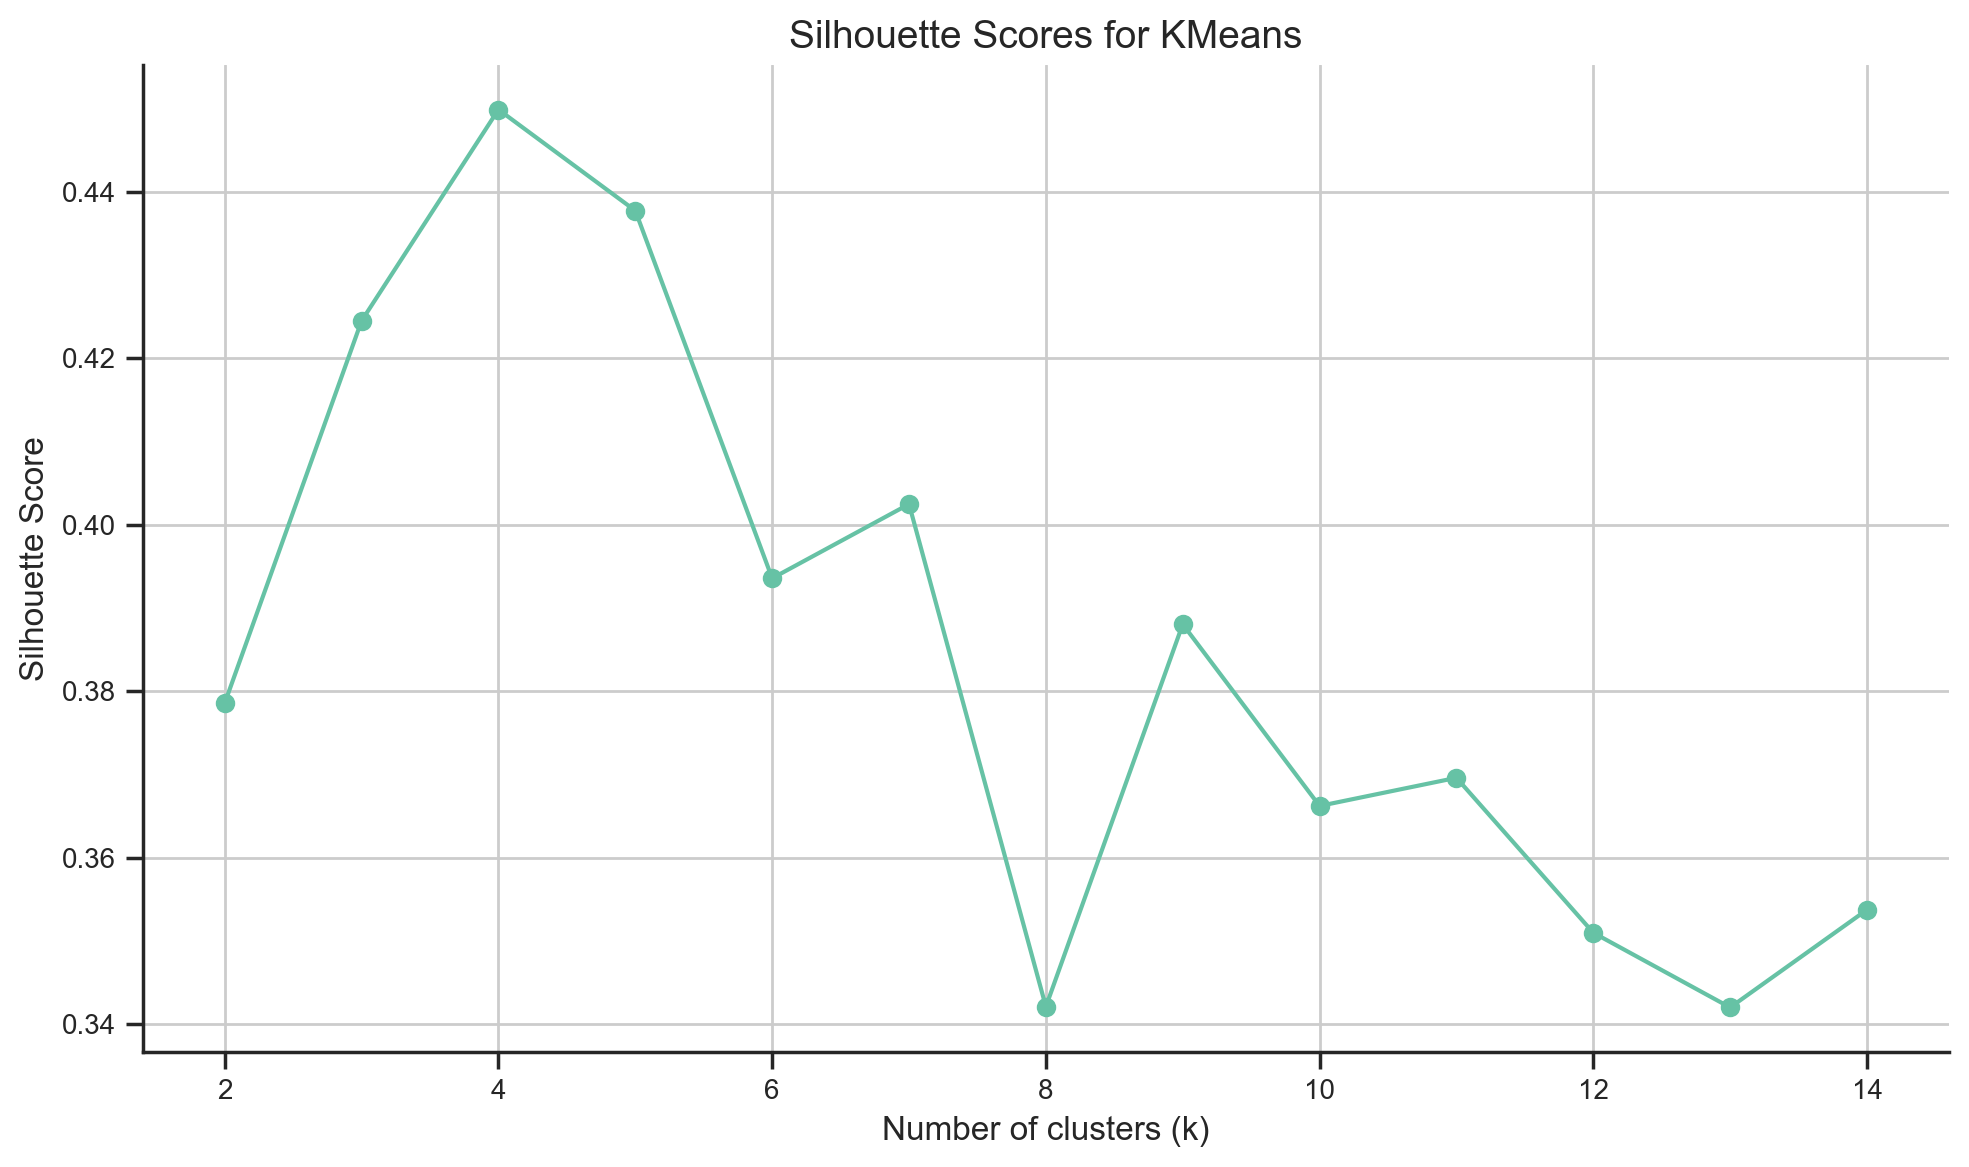

In [19]:
# Silhoutte Score
k_values = range(2, 15)

kmeans_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    labels_kmeans = kmeans.fit_predict(data_tmp_scaled)
    score = silhouette_score(data_tmp_scaled, labels_kmeans)
    kmeans_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(k_values, kmeans_scores, label='KMeans', marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for KMeans')
plt.grid(True)

plt.tight_layout()
plt.show()

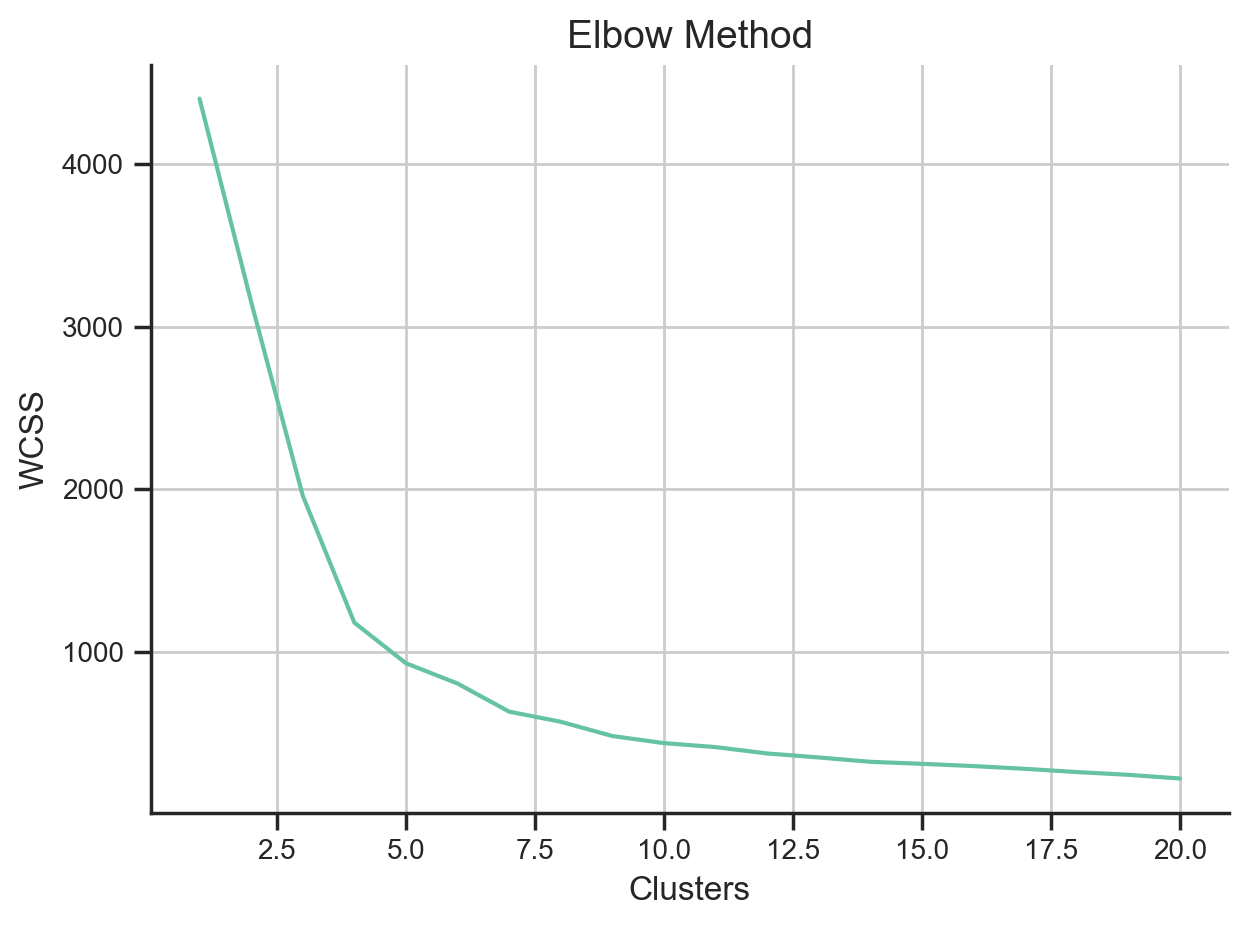

In [20]:
## Elbow

wcss = list()


for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=1234)
    kmeans.fit(data_tmp_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,21), wcss)
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.grid(True)

plt.tight_layout()
plt.show()


In [21]:
## Model with 4 clusters

kmeans = KMeans(n_clusters=4)
kmeans.fit(data_tmp_scaled)

data_rfm_tmp['CLUSTER'] = kmeans.labels_

data_rfm_tmp['CLUSTER'].value_counts().sort_index()

CLUSTER
0    161
1    752
2    550
3      5
Name: count, dtype: int64

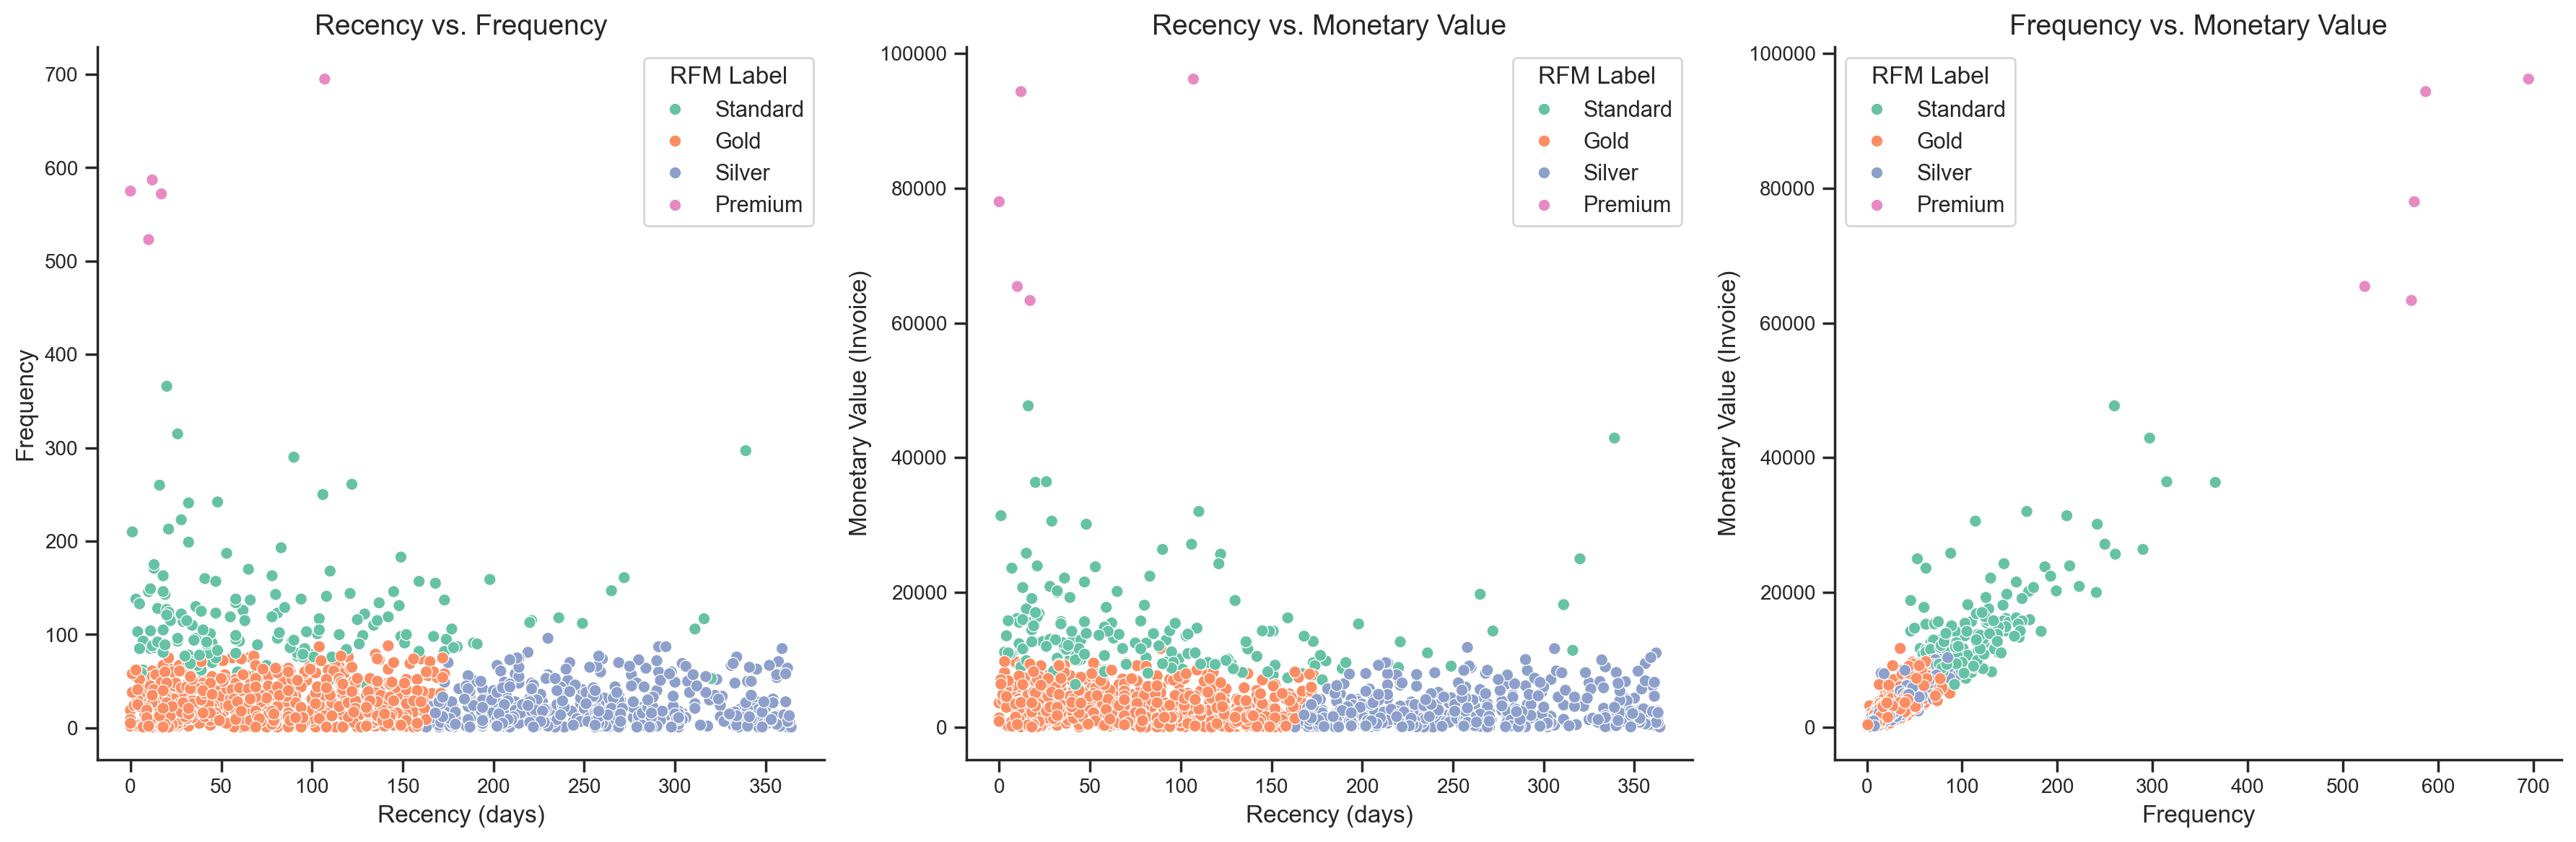

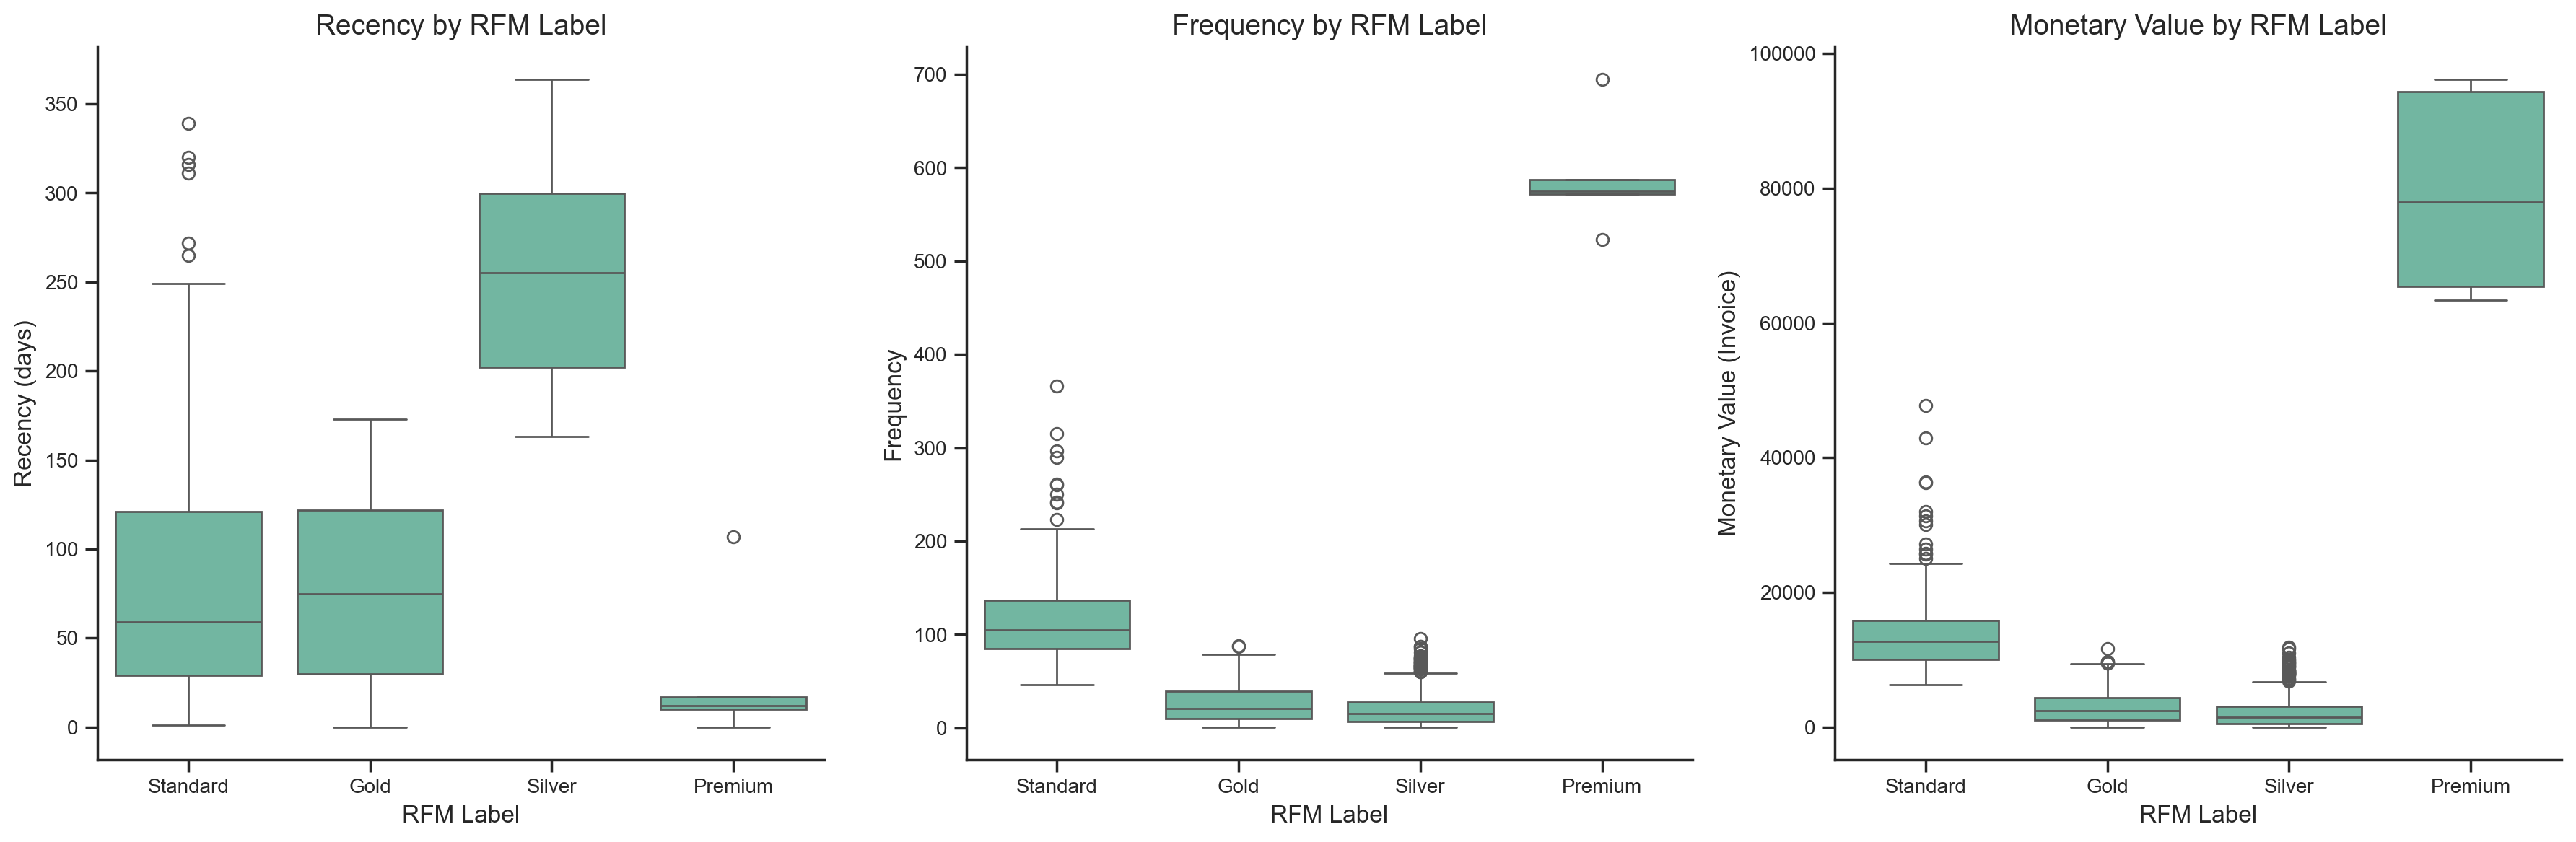

In [22]:
# Plot the Groups

## I plotted the data before and defined the labels for each group considerinf the names: Premium, Gold, Silver and Standart
# Mapping dictionary
rfm_mapping = {
    0: 'Standard',
    1: 'Gold',
    2: 'Silver',
    3: 'Premium'
}

# Convert the data to categorical data
data_rfm_tmp['CLUSTER'] = data_rfm_tmp['CLUSTER'].astype('category')

# Relabel
data_rfm_tmp['CLUSTER_rename'] = data_rfm_tmp['CLUSTER'].map(rfm_mapping) 

# Plot
plot_rfm_clusters(data_rfm_tmp, 'recency_days', 'frequency', 'Invoice', 'CLUSTER_rename')

**Strategies for Each Segment**
1. Premium Customers:
   - **Personalized Offers**: Provide exclusive discounts and personalized product recommendations based on their purchase history.
   - **Exclusive Previews**: Offer early access to new products, sales, or events to make them feel valued.
   - **Loyalty Programs**: Enhance loyalty programs with benefits like points multipliers, exclusive rewards, or tiered memberships.
   - **Premium Services**: Offer premium services such as free expedited shipping, dedicated customer support, and easy returns.
2. Gold Customers
    - **Upsell and Cross-Sell**: Encourage higher-value purchases by recommending complementary products or higher-end items.
    - **Engagement Campaigns**: Keep them engaged with regular updates, newsletters, and special promotions.
    - **Feedback Requests**: Solicit feedback to understand their needs better and improve their experience.
    - **Loyalty Incentives**: Provide loyalty incentives such as discounts on the next purchase or bonus points for referring friends.
3. Silver Customers
    - **Discounts and Promotions**: Offer time-limited discounts or bundle deals to encourage purchases.
    - **Re-engagement Emails**: Send personalized re-engagement emails highlighting new arrivals, special offers, or upcoming sales.
    - **Loyalty Programs**: Introduce or promote a loyalty program to encourage more frequent shopping.
    - **Educational Content**: Share content that educates them about your products and their benefits, possibly through blog posts, videos, or tutorials.
4. Standard Customers
    - **Awareness Campaigns**: Use targeted social media ads and content marketing to increase brand awareness.
    - **First Purchase Incentives**: Offer welcome discounts and free samples to encourage initial purchases.
    - **Re-engagement Campaigns**: Send email reminders about new products, special offers, and win-back campaigns.
    - **Educational Content**: Provide product guides, tutorials, and customer success stories to build trust.
    - **Personalized Recommendations**: Use tailored product suggestions and customized email campaigns.
    - **Exclusive Offers**: Create special promotions and limited-time offers to encourage immediate purchases.

#### Comparing the two models

In [23]:
# Comparing the two methods

# Get the counts of rfm_label and CLUSTER combinations
table_cluster = data_rfm_tmp[['rfm_label_rename', 'CLUSTER_rename']].value_counts().reset_index(name='qtde')

# Pivot the table to get rfm_label as values and CLUSTER as index
table_cluster_pivot = table_cluster.pivot_table(index='CLUSTER_rename', columns='rfm_label_rename', values='qtde', fill_value=0)

table_cluster_pivot

rfm_label_rename,Standard,Silver,Gold,Premium
CLUSTER_rename,,,,
Standard,0.00,0.00,24.00,137.00
Gold,111.00,233.00,277.00,131.00
Silver,299.00,163.00,88.00,0.00
Premium,0.00,0.00,0.00,5.00


In [24]:
# Calculate the proportions
total = table_cluster_pivot.values.sum()
# proportions = table_cluster_pivot.div(table_cluster_pivot.sum(axis=0), axis=1)
proportions = table_cluster_pivot/total*100

# Calculate the accuracy 
total_correct = table_cluster_pivot.values.diagonal().sum()
accuracy = total_correct/total

print("Proportions:\n")
display(proportions)
print(f"\nAccuracy: {round(accuracy*100,2)}% are in the 'same group'.")

Proportions:



rfm_label_rename,Standard,Silver,Gold,Premium
CLUSTER_rename,,,,
Standard,0.00,0.00,1.63,9.33
Gold,7.56,15.87,18.87,8.92
Silver,20.37,11.10,5.99,0.00
Premium,0.00,0.00,0.00,0.34



Accuracy: 22.21% are in the 'same group'.


- The heuristic-based segmentation and the KMeans clustering showed significant differences in how customers are classified into the four groups. The heuristic approach divided the groups considering percentiles, with each group having the same size, making this approach less flexible.
- While the overall accuracy of 45.23% indicates some level of consistency, the variation in the group distributions suggests that the clustering method might be capturing more nuanced customer behaviors not accounted for in the heuristic approach.

## 4. Predicting Customer Lifetime Value (Low Value/Medium Value/High Value)

**IMPORTANT**: For defining CLT, it is necessary to have more information about customers. Therefore, using just Revenue/Invoice is not the best choice. Thinking about it, I will just use a model to test, but I won't try other approaches at this moment.
An alternative I am thinking of is using the Cluster to classify new clients, but I will try it later, after finishing the main questions.

"In the current world, almost every retailer promotes its subscription and this is further used to understand the customer lifetime. Retailer can manage these customers in better manner if they know which customer is high life time value. Customer lifetime value (LTV) can also be defined as the monetary value of a customer relationship, based on the present value of the projected future cash flows from the customer relationship.  
ustomer lifetime value is an important concept in that it encourages firms to shift their focus from quarterly profits to the long-term health of their customer relationships. Customer lifetime value is an important metric because it represents an upper limit on spending to acquire new customers. For this reason it is an important element in calculating payback of advertising spent in marketing mix modelling."


### 4.1. First define dependent variable with categories low value, medium value, high value using customer revenue.  

In [25]:
# Average Value of Sale

data_tmp['CLV_Category']  = pd.qcut(data_tmp['Invoice'], q = 3, labels = ['Low', 'Medium', 'High'])

In [26]:
# Creating a new dataset
columns = ['CustomerID', 'Transaction_ID', 'Discount_pct_ajus', 'Invoice', 'Location', 'Tenure_Months', 'CLV_Category']
clv_tmp = data_tmp[columns]

##### Feature Engineering

In [27]:
# Total number of orders per customer
orders_per_customer = clv_tmp.groupby('CustomerID')['Transaction_ID'].nunique()

# Tenure
tenure_per_customer = clv_tmp.groupby('CustomerID')['Tenure_Months'].max()

# Number of orders that used a discount coupon
discount_orders_per_customer = clv_tmp[clv_tmp['Discount_pct_ajus']>0].groupby('CustomerID')['Transaction_ID'].count()

# Average discount percentage.
avg_discount_per_customer = clv_tmp.groupby('CustomerID')['Discount_pct_ajus'].mean()

# Average invoice amount per order
avg_invoice_per_customer = clv_tmp.groupby('CustomerID')['Invoice'].mean()

# Combine all features into a single DataFrame
features = pd.DataFrame({
    'Total_Orders': orders_per_customer,
    'Tenure_Months': tenure_per_customer,
    'Discount_Orders': discount_orders_per_customer,
    'Avg_Discount': avg_discount_per_customer,
    'Avg_Invoice': avg_invoice_per_customer,
    'Location': clv_tmp.groupby('CustomerID')['Location'].first(),
    'CLV_Category': clv_tmp.groupby('CustomerID')['CLV_Category'].first()
}).reset_index()

# Fill NaN values for customers with no discount orders
features['Discount_Orders'] = features['Discount_Orders'].fillna(0)

In [28]:
features

,CustomerID,Total_Orders,Tenure_Months,Discount_Orders,Avg_Discount,Avg_Invoice,Location,CLV_Category
0,12346,1,31,2.00,30.00,100.49,New York,Medium
1,12347,31,20,20.00,8.00,296.21,New York,Low
2,12348,8,39,11.00,11.74,88.99,California,High
3,12350,11,25,6.00,10.59,110.43,California,High
4,12356,13,31,11.00,9.17,70.89,Chicago,Low
...,...,...,...,...,...,...,...,...
1463,18259,3,5,3.00,4.29,126.94,California,High
1464,18260,19,43,16.00,9.25,90.50,New York,Low
1465,18269,2,25,3.00,3.75,21.97,Chicago,Low
1466,18277,1,47,0.00,0.00,333.80,Chicago,High


In [29]:
features.to_csv('DATA/features_model_5.csv')

#### Build and Train the Classification Model

**Random Forest**

In [30]:
# Convert categorical feature 'Location' to numerical
features = pd.get_dummies(features, columns=['Location'], drop_first=True)

# Split columns features and Target
X = features.drop(['CustomerID', 'CLV_Category'], axis = 1)
y = features['CLV_Category']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize and train the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        High       0.52      0.40      0.45        87
         Low       0.36      0.39      0.38        84
      Medium       0.49      0.54      0.52       123

    accuracy                           0.46       294
   macro avg       0.46      0.45      0.45       294
weighted avg       0.46      0.46      0.46       294



**Logistic**

In [31]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the logistic regression model
log_reg = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.42      0.36      0.39        87
         Low       0.41      0.29      0.34        84
      Medium       0.44      0.59      0.51       123

    accuracy                           0.43       294
   macro avg       0.43      0.41      0.41       294
weighted avg       0.43      0.43      0.42       294

